In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [43]:
df_train = pd.read_csv(
    "data/assignment_2_train.csv"
)

df_test = pd.read_csv(
    "data/assignment_2_test.csv"
)

print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 180000 rows, 394 cols
df_test.shape = 100001 rows, 394 cols


Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

In [44]:
df_train, df_valid = train_test_split(df_train, test_size=0.30,  random_state=42)
print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 126000 rows, 394 cols
df_valid.shape = 54000 rows, 394 cols
df_test.shape = 100001 rows, 394 cols


In [45]:
y_train = df_train['isFraud']
y_valid = df_valid['isFraud']
y_test = df_test['isFraud']

df_train.drop(['isFraud'], axis='columns', inplace=True)
df_valid.drop(['isFraud'], axis='columns', inplace=True)
df_test.drop(['isFraud'], axis='columns', inplace=True)

In [46]:
df_train.drop(['TransactionID'], axis='columns', inplace=True)
df_valid.drop(['TransactionID'], axis='columns', inplace=True)
df_test.drop(['TransactionID'], axis='columns', inplace=True)

In [29]:
numeric_feature = df_train.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_train.columns) - set(numeric_feature))

df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

for c in сategorical_feature:
    df_train_d[c] = df_train_d[c].astype('category')
    df_valid_d[c] = df_valid_d[c].astype('category')
    df_test_d[c] = df_test_d[c].astype('category')

In [32]:
print(f"count of categorical_df_train {df_train_d.shape}")
print(f"count of categorical_df_valid {df_valid_d.shape}")
print(f"count of categorical_df_test {df_test_d.shape}")

count of categorical_df_train (126000, 392)
count of categorical_df_valid (54000, 392)
count of categorical_df_test (100001, 392)


In [8]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 500,
    "n_jobs": 6,
    "seed": 27
}

In [10]:
dtrain = lgb.Dataset(
    data=df_train_d, label=y_train, categorical_feature=сategorical_feature
)
dvalid = lgb.Dataset(
    data=df_valid_d, label=y_valid, categorical_feature=сategorical_feature
)
# dtest = lgb.Dataset(
#     data=df_test_d, categorical_feature=сategorical_feature
# )

In [11]:
model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.952964	valid_1's auc: 0.925705
[100]	training's auc: 0.974406	valid_1's auc: 0.936442
[150]	training's auc: 0.985421	valid_1's auc: 0.942571
[200]	training's auc: 0.990588	valid_1's auc: 0.946136
[250]	training's auc: 0.994026	valid_1's auc: 0.949236
[300]	training's auc: 0.996085	valid_1's auc: 0.951505
[350]	training's auc: 0.997285	valid_1's auc: 0.952645
[400]	training's auc: 0.99823	valid_1's auc: 0.952849
[450]	training's auc: 0.998672	valid_1's auc: 0.953661
[500]	training's auc: 0.999077	valid_1's auc: 0.95415
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.999077	valid_1's auc: 0.95415


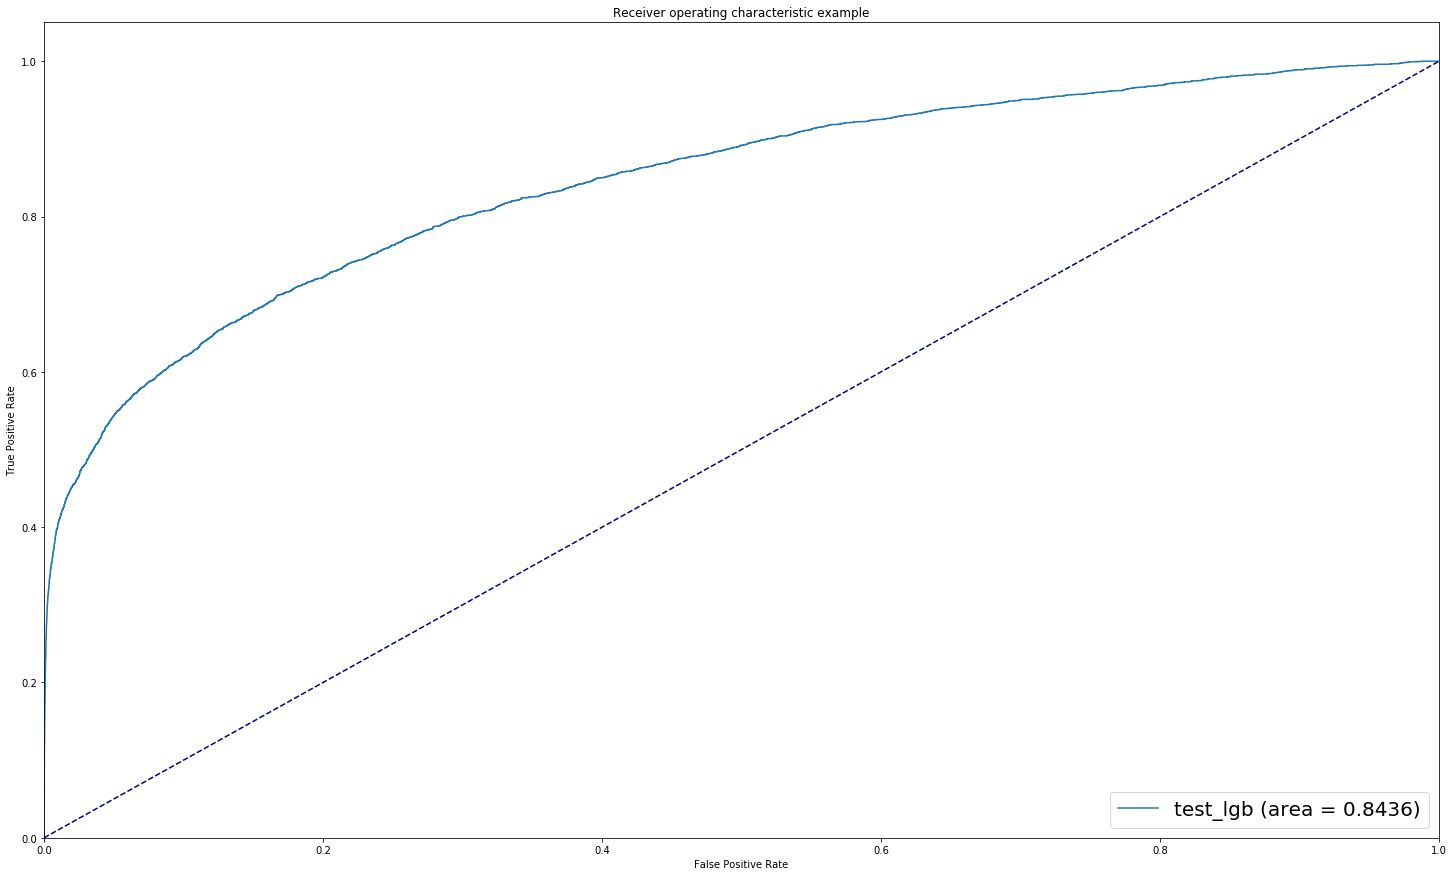

In [13]:
fig = plt.figure(figsize=(25, 15))

#------------------------------------------------------------------------------
#lgb
pred = model_lgb.predict(df_test_d)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [14]:
import datetime 
zero_date = datetime.datetime(2017, 12, 1)
print(zero_date)
print(int(zero_date.timestamp()))
zero_date = int(zero_date.timestamp())

2017-12-01 00:00:00
1512068400


In [15]:
df_train_d.loc[:, ['TransactionDT']] = df_train_d.loc[:, ['TransactionDT']] + zero_date
df_valid_d.loc[:, ['TransactionDT']] = df_valid_d.loc[:, ['TransactionDT']] + zero_date
df_test_d.loc[:, ['TransactionDT']] = df_test_d.loc[:, ['TransactionDT']] + zero_date

In [16]:
df_train_d['DT'] = pd.to_datetime(df_train_d['TransactionDT'].values, unit='s', origin='unix')
df_valid_d['DT'] = pd.to_datetime(df_valid_d['TransactionDT'].values, unit='s', origin='unix')
df_test_d['DT'] = pd.to_datetime(df_test_d['TransactionDT'].values, unit='s', origin='unix')

df_train_d.drop(['TransactionDT'], axis='columns', inplace=True)
df_valid_d.drop(['TransactionDT'], axis='columns', inplace=True)
df_test_d.drop(['TransactionDT'], axis='columns', inplace=True)

In [17]:
def date_param_add(data: pd.DataFrame,
                  datatime_column: str) -> pd.DataFrame:
    """
    

    """
    data_copy = data.copy()

    data_copy['year'] = data_copy[datatime_column].dt.year
    data_copy['month'] = data_copy[datatime_column].dt.month
    data_copy['day'] = data_copy[datatime_column].dt.day
    data_copy['hour'] = data_copy[datatime_column].dt.hour
    data_copy['minute'] = data_copy[datatime_column].dt.minute
    data_copy['dayofweek'] = data_copy[datatime_column].dt.dayofweek
    
    data_copy.drop([datatime_column], axis='columns', inplace=True)
    return data_copy

df_train_d = date_param_add(df_train_d, 'DT')
df_valid_d = date_param_add(df_valid_d, 'DT')
df_test_d = date_param_add(df_test_d, 'DT')

In [18]:
dtrain = lgb.Dataset(
    data=df_train_d, label=y_train
)
dvalid = lgb.Dataset(
    data=df_valid_d, label=y_valid
)
# dtest = lgb.Dataset(
#     data=df_test_dummy, label=y_test
# )

In [19]:
model_lgb_1 = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50,
            
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.953731	valid_1's auc: 0.924231
[100]	training's auc: 0.975042	valid_1's auc: 0.936884
[150]	training's auc: 0.986316	valid_1's auc: 0.942954
[200]	training's auc: 0.992018	valid_1's auc: 0.947419
[250]	training's auc: 0.994892	valid_1's auc: 0.949322
[300]	training's auc: 0.996806	valid_1's auc: 0.950518
[350]	training's auc: 0.997985	valid_1's auc: 0.951548
[400]	training's auc: 0.998861	valid_1's auc: 0.952272
[450]	training's auc: 0.999365	valid_1's auc: 0.952899
[500]	training's auc: 0.999636	valid_1's auc: 0.953769
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.999636	valid_1's auc: 0.953769


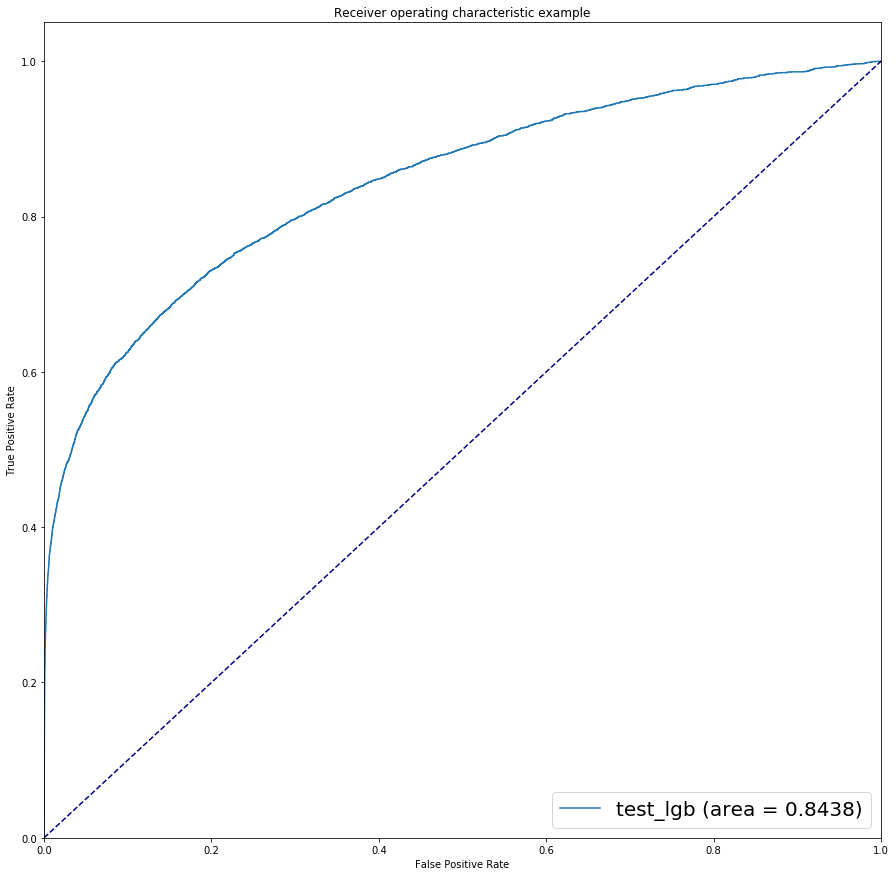

In [20]:
fig = plt.figure(figsize=(15, 15))

#------------------------------------------------------------------------------
#lgb
pred = model_lgb_1.predict(df_test_d)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

Я еще на 2 занятии говорил, что если расписать время, то точность увеличится.

Задание 2: сделать конкатенацию признаков
* card1 + card2;
* card1 + card2 + card_3 + card_5;
* card1 + card2 + card_3 + card_5 + addr1 + addr2

Рассматривать их как категориальных признаки.

In [39]:
def create_feature(data: pd.DataFrame) -> pd.DataFrame:
    """
    

    """
    data_copy = data.loc[:, ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']].copy()
        
    data_copy['card1'] = data_copy['card1'].astype('str')
    data_copy['card2'] = data_copy['card2'].astype('str')
    data_copy['card3'] = data_copy['card3'].astype('str')
    #data_copy['card4'] = data_copy['card4'].astype('category')
    data_copy['card5'] = data_copy['card5'].astype('str')
    data_copy['addr1'] = data_copy['addr1'].astype('str')
    data_copy['addr2'] = data_copy['addr2'].astype('str')
    
    data_copy['card1+card2'] = data_copy['card1']+'|'+data_copy['card2']
    data_copy['card1+card2+card3+card5'] = \
    data_copy['card1']+'|'+data_copy['card2']+'|'+data_copy['card3']+'|'+data_copy['card5']
    data_copy['card1+card2+card3+card5+addr1+addr2'] = \
    data_copy['card1']+'|'+data_copy['card2']+'|'+data_copy['card3']+'|'+data_copy['card5']\
    +'|'+ data_copy['addr1']+'|'+ data_copy['addr2']
   
    data_copy.drop(['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'], axis='columns', inplace=True)

    return data_copy

In [40]:
combo_train = create_feature(df_train)
combo_valid = create_feature(df_valid)
combo_test = create_feature(df_test)

In [41]:
combo_train['card1+card2+card3+card5+addr1+addr2'].value_counts()

15885|545.0|185.0|138.0|nan|nan       2151
17188|321.0|150.0|226.0|299.0|87.0    1198
12695|490.0|150.0|226.0|325.0|87.0    1149
3154|408.0|185.0|224.0|nan|nan         958
9633|296.0|185.0|138.0|nan|nan         902
                                      ... 
10448|555.0|150.0|226.0|325.0|87.0       1
15063|514.0|150.0|226.0|nan|nan          1
9350|111.0|150.0|162.0|123.0|87.0        1
8994|399.0|150.0|236.0|143.0|87.0        1
15289|399.0|150.0|236.0|126.0|87.0       1
Name: card1+card2+card3+card5+addr1+addr2, Length: 21821, dtype: int64

In [49]:
df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

df_train_d = df_train_d.join(combo_train)
df_valid_d = df_valid_d.join(combo_valid)
df_test_d = df_test_d.join(combo_test)

numeric_feature = df_train_d.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_train_d.columns) - set(numeric_feature))


for c in сategorical_feature:
    df_train_d[c] = df_train_d[c].astype('category')
    df_valid_d[c] = df_valid_d[c].astype('category')
    df_test_d[c] = df_test_d[c].astype('category')

print(f"count of categorical_df_train {df_train_d.shape}")
print(f"count of categorical_df_valid {df_valid_d.shape}")
print(f"count of categorical_df_test {df_test_d.shape}")

count of categorical_df_train (126000, 395)
count of categorical_df_valid (54000, 395)
count of categorical_df_test (100001, 395)


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.975837	valid_1's auc: 0.936715
[100]	training's auc: 0.989357	valid_1's auc: 0.945053
[150]	training's auc: 0.994246	valid_1's auc: 0.94957
[200]	training's auc: 0.996652	valid_1's auc: 0.950911
[250]	training's auc: 0.997891	valid_1's auc: 0.952301
[300]	training's auc: 0.998715	valid_1's auc: 0.953549
[350]	training's auc: 0.999289	valid_1's auc: 0.954426
[400]	training's auc: 0.999545	valid_1's auc: 0.954671
[450]	training's auc: 0.999699	valid_1's auc: 0.954991
[500]	training's auc: 0.99985	valid_1's auc: 0.9554
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.99985	valid_1's auc: 0.9554


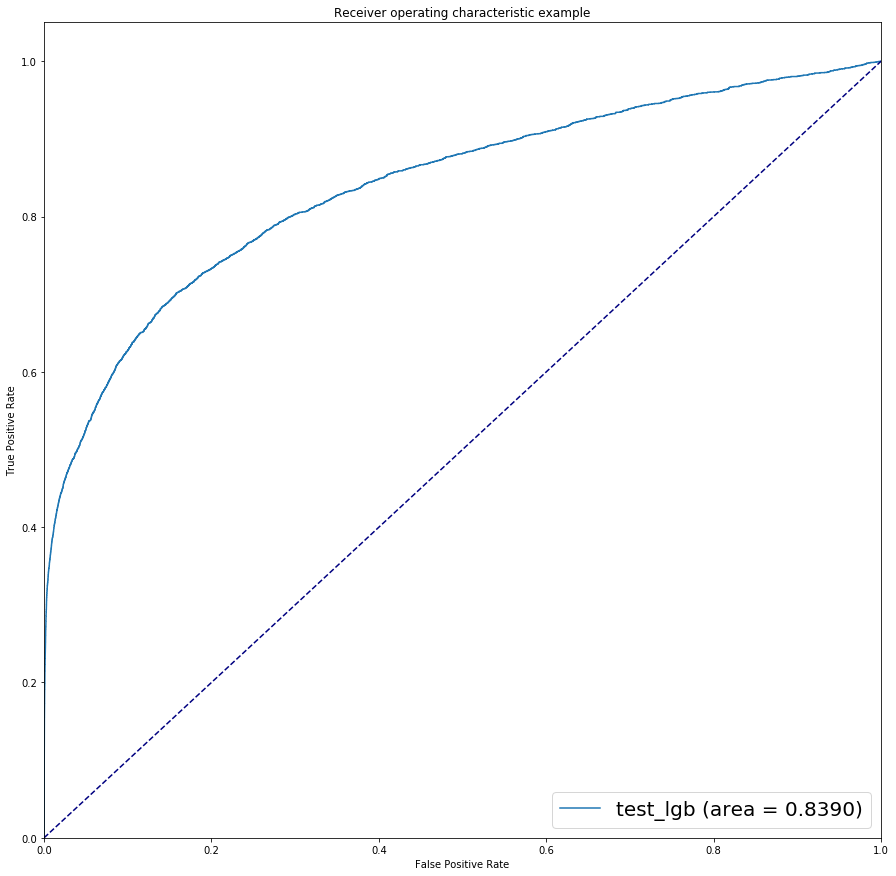

In [53]:
dtrain = lgb.Dataset(
    data=df_train_d, label=y_train
)
dvalid = lgb.Dataset(
    data=df_valid_d, label=y_valid
)

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50            
)

fig = plt.figure(figsize=(15, 15))

#------------------------------------------------------------------------------
#lgb
pred = model_lgb.predict(df_test_d)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

Естественно такое кол-во категорий в 
    card1 + card2;
    card1 + card2 + card_3 + card_5;
    card1 + card2 + card_3 + card_5 + addr1 + addr2
только ухудшило модель.

Задание 3: Сделать FrequencyEncoder для признаков card1 - card6, addr1, addr2.

In [54]:
df_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
147486,3025196,108.50,W,15066,170.0,150.0,mastercard,102.0,credit,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16510,437079,35.95,W,18132,567.0,150.0,mastercard,117.0,debit,337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118552,2316035,625.95,W,2616,NaN,150.0,discover,102.0,credit,441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114216,2222363,59.00,W,10616,583.0,150.0,visa,226.0,credit,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5275,174608,539.00,W,3821,111.0,150.0,mastercard,219.0,credit,327.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
def create_freq_encoder(data: pd.DataFrame) -> pd.DataFrame:
    """
    

    """
    data_copy = data.loc[:, ['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2']].copy()
        
    сol = data_copy.columns
    
    for c in сol:
        freq_encoder = data_copy[c].value_counts(normalize=True)
        #print(freq_encoder)
        data_copy[c+'_freq_encoder'] = data_copy[c].map(freq_encoder)
   
    data_copy.drop(['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2'], axis='columns', inplace=True)

    return data_copy

In [100]:
freq_encoder_train = create_freq_encoder(df_train)
freq_encoder_valid = create_freq_encoder(df_valid)
freq_encoder_test = create_freq_encoder(df_test)

In [69]:
freq_encoder_train.head()

,card1_freq_encoder,card2_freq_encoder,card3_freq_encoder,card4_freq_encoder,card5_freq_encoder,addr1_freq_encoder,addr2_freq_encoder
147486,0.014095,0.037588,0.879562,0.302660,0.055023,0.078874,0.982332
16510,0.006659,0.010164,0.879562,0.302660,0.037312,0.030052,0.982332
118552,0.008913,NaN,0.879562,0.013572,0.055023,0.038405,0.982332
114216,0.011119,0.054727,0.879562,0.657148,0.513610,0.078874,0.982332
5275,0.003183,0.076110,0.879562,0.302660,0.022450,0.015542,0.982332


In [70]:
df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

df_train_d = df_train_d.join(freq_encoder_train)
df_valid_d = df_valid_d.join(freq_encoder_valid)
df_test_d = df_test_d.join(freq_encoder_test)

numeric_feature = df_train_d.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_train_d.columns) - set(numeric_feature))


for c in сategorical_feature:
    df_train_d[c] = df_train_d[c].astype('category')
    df_valid_d[c] = df_valid_d[c].astype('category')
    df_test_d[c] = df_test_d[c].astype('category')

print(f"count of categorical_df_train {df_train_d.shape}")
print(f"count of categorical_df_valid {df_valid_d.shape}")
print(f"count of categorical_df_test {df_test_d.shape}")

count of categorical_df_train (126000, 399)
count of categorical_df_valid (54000, 399)
count of categorical_df_test (100001, 399)


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.957089	valid_1's auc: 0.926292
[100]	training's auc: 0.979174	valid_1's auc: 0.938641
[150]	training's auc: 0.987526	valid_1's auc: 0.944263
[200]	training's auc: 0.992969	valid_1's auc: 0.947869
[250]	training's auc: 0.995497	valid_1's auc: 0.949273
[300]	training's auc: 0.997355	valid_1's auc: 0.951083
[350]	training's auc: 0.998368	valid_1's auc: 0.952398
[400]	training's auc: 0.998978	valid_1's auc: 0.952518
[450]	training's auc: 0.999373	valid_1's auc: 0.953059
[500]	training's auc: 0.999655	valid_1's auc: 0.954154
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.999655	valid_1's auc: 0.954154


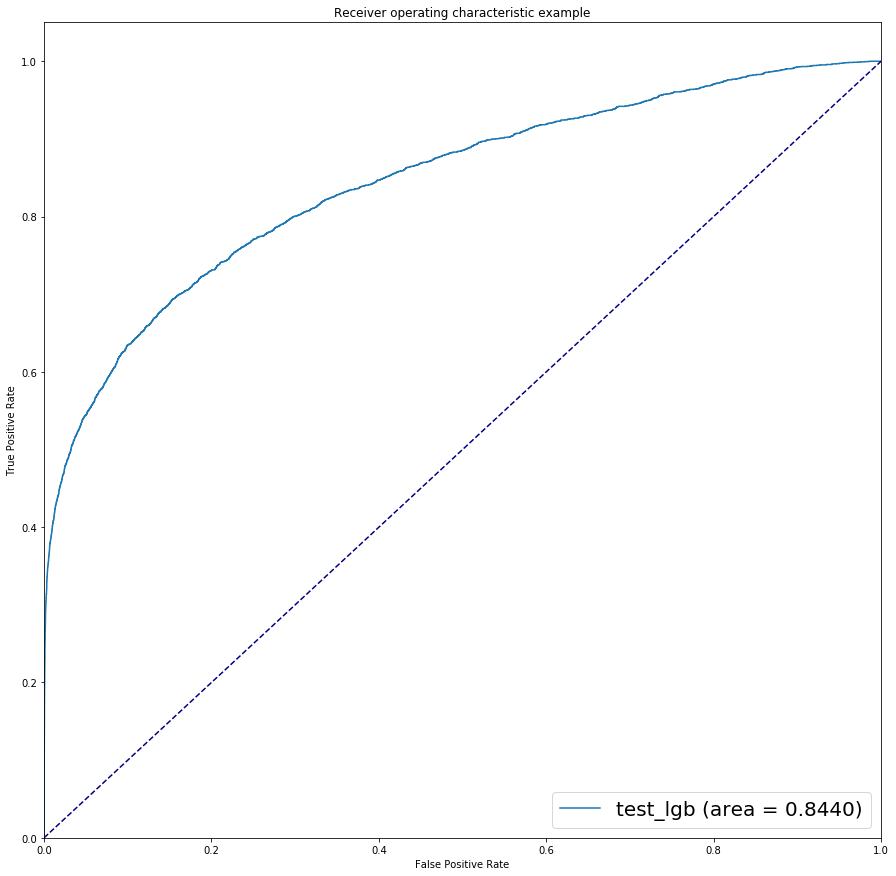

In [71]:
dtrain = lgb.Dataset(
    data=df_train_d, label=y_train
)
dvalid = lgb.Dataset(
    data=df_valid_d, label=y_valid
)

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50            
)

fig = plt.figure(figsize=(15, 15))

#------------------------------------------------------------------------------
#lgb
pred = model_lgb.predict(df_test_d)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

Результат улучшился, фичу можно добавлять в финале. 

Задание 4: Создать признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [149]:
def create_stat(data: pd.DataFrame) -> pd.DataFrame:
    """
    

    """
    data_copy = data.loc[:, ['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2', 'TransactionAmt',
                             'card1+card2',
                             'card1+card2+card3+card5',
                             'card1+card2+card3+card5+addr1+addr2']].copy()
        
    
    сol = ['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2',
                             'card1+card2',
                             'card1+card2+card3+card5',
                             'card1+card2+card3+card5+addr1+addr2']
    
    data_copy['card1+card2'] = data_copy['card1+card2'].astype('str')
    data_copy['card1+card2+card3+card5'] = data_copy['card1+card2+card3+card5'].astype('str')
    data_copy['card1+card2+card3+card5+addr1+addr2'] = data_copy['card1+card2+card3+card5+addr1+addr2'].astype('str')
    
    def f(x):     
        if np.std(x) != 0:
            return np.mean(x)/np.std(x)
        else:
            return 0   
    
    for c in сol:
        table = pd.pivot_table(data_copy, values='TransactionAmt', index=[c], aggfunc=f)
        table_ = pd.Series(table['TransactionAmt'], table.index)
        data_copy[c+'_prosto_ahrenet_kaka_ficha'] = data_copy[c].map(table_)
   
    data_copy.drop(['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2', 'TransactionAmt',
                            'card1+card2',
                             'card1+card2+card3+card5',
                             'card1+card2+card3+card5+addr1+addr2'], axis='columns', inplace=True)

    return data_copy

In [150]:
stat_train = create_stat(df_train.join(combo_train))
stat_valid = create_stat(df_valid.join(combo_valid))
stat_test = create_stat(df_test.join(combo_test))

In [151]:
df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

df_train_d = df_train_d.join(stat_train)
df_valid_d = df_valid_d.join(stat_valid)
df_test_d = df_test_d.join(stat_test)

numeric_feature = df_train_d.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_train_d.columns) - set(numeric_feature))


for c in сategorical_feature:
    df_train_d[c] = df_train_d[c].astype('category')
    df_valid_d[c] = df_valid_d[c].astype('category')
    df_test_d[c] = df_test_d[c].astype('category')

print(f"count of categorical_df_train {df_train_d.shape}")
print(f"count of categorical_df_valid {df_valid_d.shape}")
print(f"count of categorical_df_test {df_test_d.shape}")

count of categorical_df_train (126000, 402)
count of categorical_df_valid (54000, 402)
count of categorical_df_test (100001, 402)


In [155]:
df_train_d.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,card1_prosto_ahrenet_kaka_ficha,card2_prosto_ahrenet_kaka_ficha,card3_prosto_ahrenet_kaka_ficha,card4_prosto_ahrenet_kaka_ficha,card5_prosto_ahrenet_kaka_ficha,addr1_prosto_ahrenet_kaka_ficha,addr2_prosto_ahrenet_kaka_ficha,card1+card2_prosto_ahrenet_kaka_ficha,card1+card2+card3+card5_prosto_ahrenet_kaka_ficha,card1+card2+card3+card5+addr1+addr2_prosto_ahrenet_kaka_ficha
147486,3025196,108.50,W,15066,170.0,150.0,mastercard,102.0,credit,204.0,...,0.703398,0.648411,0.656112,0.621828,0.664347,0.685171,0.656646,0.703398,0.703398,0.749864
16510,437079,35.95,W,18132,567.0,150.0,mastercard,117.0,debit,337.0,...,0.655451,0.730927,0.656112,0.621828,0.703048,0.694806,0.656646,0.655451,0.655451,0.722837
118552,2316035,625.95,W,2616,NaN,150.0,discover,102.0,credit,441.0,...,0.689398,NaN,0.656112,0.664112,0.664347,0.679852,0.656646,0.838856,0.838856,1.140896
114216,2222363,59.00,W,10616,583.0,150.0,visa,226.0,credit,204.0,...,0.666597,0.675613,0.656112,0.631681,0.643881,0.685171,0.656646,0.666597,0.666597,0.941262
5275,174608,539.00,W,3821,111.0,150.0,mastercard,219.0,credit,327.0,...,0.720379,0.662051,0.656112,0.621828,0.662263,0.706338,0.656646,0.720379,0.720379,1.554502


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.955205	valid_1's auc: 0.916258
[100]	training's auc: 0.977714	valid_1's auc: 0.926878
[150]	training's auc: 0.987517	valid_1's auc: 0.933661
[200]	training's auc: 0.992782	valid_1's auc: 0.936485
[250]	training's auc: 0.995613	valid_1's auc: 0.938018
[300]	training's auc: 0.997498	valid_1's auc: 0.940537
[350]	training's auc: 0.998529	valid_1's auc: 0.941368
[400]	training's auc: 0.999038	valid_1's auc: 0.942628
[450]	training's auc: 0.999385	valid_1's auc: 0.943119
[500]	training's auc: 0.999601	valid_1's auc: 0.943519
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.999601	valid_1's auc: 0.943519


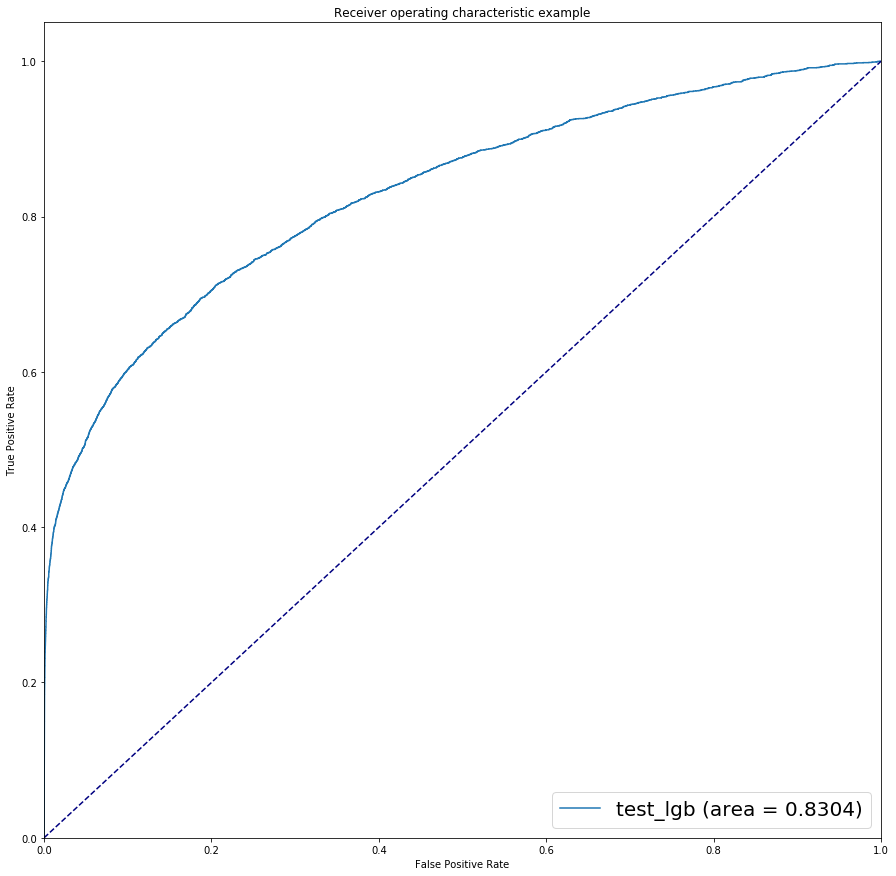

In [152]:
dtrain = lgb.Dataset(
    data=df_train_d, label=y_train
)
dvalid = lgb.Dataset(
    data=df_valid_d, label=y_valid
)

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50            
)

fig = plt.figure(figsize=(15, 15))

#------------------------------------------------------------------------------
#lgb
pred = model_lgb.predict(df_test_d)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

...

Задание 5: Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [166]:
def create_stat_2(data: pd.DataFrame) -> pd.DataFrame:
    """
    

    """
    data_copy = data.loc[:, ['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2', 'D15',
                             'card1+card2',
                             'card1+card2+card3+card5',
                             'card1+card2+card3+card5+addr1+addr2']].copy()
        
    
    сol = ['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2',
                             'card1+card2',
                             'card1+card2+card3+card5',
                             'card1+card2+card3+card5+addr1+addr2']
    
    data_copy['card1+card2'] = data_copy['card1+card2'].astype('str')
    data_copy['card1+card2+card3+card5'] = data_copy['card1+card2+card3+card5'].astype('str')
    data_copy['card1+card2+card3+card5+addr1+addr2'] = data_copy['card1+card2+card3+card5+addr1+addr2'].astype('str')
    
    def f(x):     
        if np.std(x) != 0:
            return np.mean(x)/np.std(x)
        else:
            return 0   
    
    for c in сol:
        table = pd.pivot_table(data_copy, values='D15', index=[c], aggfunc=f)
        table_ = pd.Series(table['D15'], table.index)
        data_copy[c+'_ficha_2'] = data_copy[c].map(table_)
   
    data_copy.drop(['card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'addr2', 'D15',
                            'card1+card2',
                             'card1+card2+card3+card5',
                             'card1+card2+card3+card5+addr1+addr2'], axis='columns', inplace=True)

    return data_copy

In [167]:
stat_train_2 = create_stat_2(df_train.join(combo_train))
stat_valid_2 = create_stat_2(df_valid.join(combo_valid))
stat_test_2 = create_stat_2(df_test.join(combo_test))

In [168]:
stat_train_2

,card1_ficha_2,card2_ficha_2,card3_ficha_2,card4_ficha_2,card5_ficha_2,addr1_ficha_2,addr2_ficha_2,card1+card2_ficha_2,card1+card2+card3+card5_ficha_2,card1+card2+card3+card5+addr1+addr2_ficha_2
147486,0.612490,0.660066,0.903551,0.778778,0.639518,0.903328,0.909141,0.612490,0.612490,0.599438
16510,0.989700,0.948012,0.903551,0.778778,0.964605,0.941537,0.909141,0.989700,0.989700,1.092857
118552,0.652217,NaN,0.903551,0.678913,0.639518,0.882938,0.909141,0.647532,0.647532,1.289413
114216,0.649002,0.703209,0.903551,0.826008,0.909740,0.903328,0.909141,0.649002,0.649002,0.618995
5275,0.913512,0.992784,0.903551,0.778778,0.743143,0.782312,0.909141,0.913512,0.913512,0.000000
...,...,...,...,...,...,...,...,...,...,...
119879,0.330990,0.337177,0.347885,0.826008,0.337450,NaN,NaN,0.330990,0.330990,0.327473
103694,0.241950,0.245998,0.347885,0.778778,0.780022,NaN,NaN,0.241950,0.241950,0.269605
131932,0.969741,0.941442,0.903551,0.826008,0.909740,0.903328,0.909141,0.969741,0.969741,0.918453
146867,0.317572,0.370174,0.347885,0.778778,0.395910,NaN,NaN,0.317572,0.317572,0.291797


In [169]:
df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

df_train_d = df_train_d.join(stat_train_2)
df_valid_d = df_valid_d.join(stat_valid_2)
df_test_d = df_test_d.join(stat_test_2)

numeric_feature = df_train_d.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_train_d.columns) - set(numeric_feature))


for c in сategorical_feature:
    df_train_d[c] = df_train_d[c].astype('category')
    df_valid_d[c] = df_valid_d[c].astype('category')
    df_test_d[c] = df_test_d[c].astype('category')

print(f"count of categorical_df_train {df_train_d.shape}")
print(f"count of categorical_df_valid {df_valid_d.shape}")
print(f"count of categorical_df_test {df_test_d.shape}")

count of categorical_df_train (126000, 402)
count of categorical_df_valid (54000, 402)
count of categorical_df_test (100001, 402)


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.955593	valid_1's auc: 0.919816
[100]	training's auc: 0.976849	valid_1's auc: 0.9315
[150]	training's auc: 0.987862	valid_1's auc: 0.938119
[200]	training's auc: 0.992767	valid_1's auc: 0.944101
[250]	training's auc: 0.995413	valid_1's auc: 0.947335
[300]	training's auc: 0.997006	valid_1's auc: 0.948323
[350]	training's auc: 0.998261	valid_1's auc: 0.949134
[400]	training's auc: 0.998908	valid_1's auc: 0.950187
[450]	training's auc: 0.999277	valid_1's auc: 0.950582
Early stopping, best iteration is:
[436]	training's auc: 0.999179	valid_1's auc: 0.950827


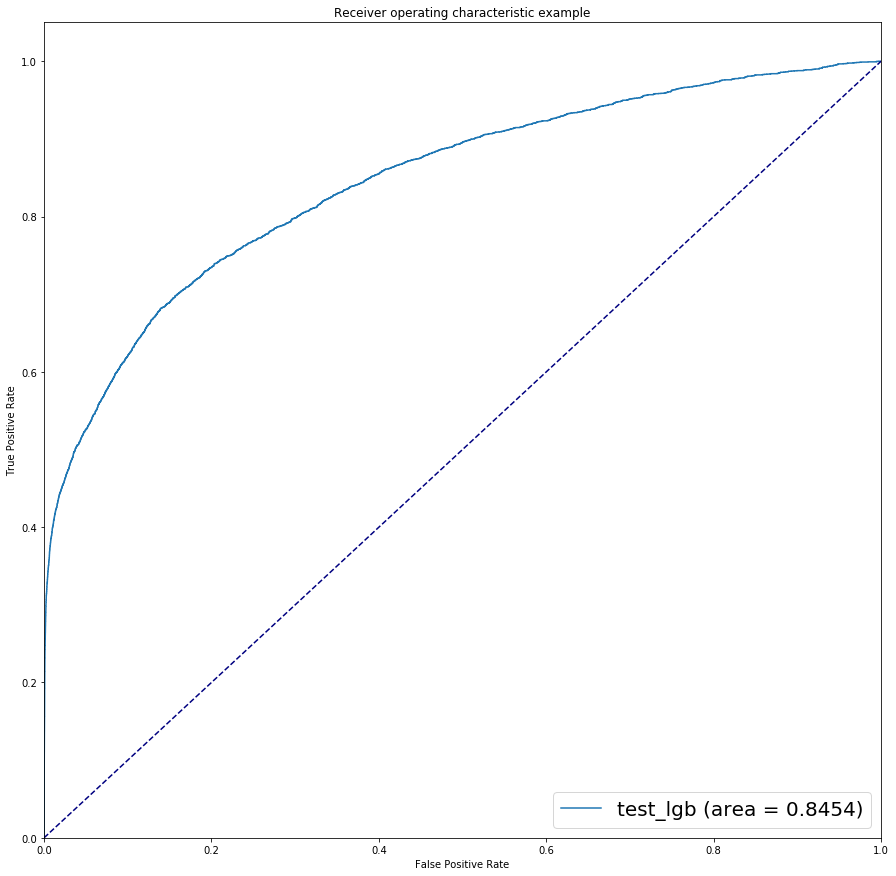

In [170]:
dtrain = lgb.Dataset(
    data=df_train_d, label=y_train
)
dvalid = lgb.Dataset(
    data=df_valid_d, label=y_valid
)

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50            
)

fig = plt.figure(figsize=(15, 15))

#------------------------------------------------------------------------------
#lgb
pred = model_lgb.predict(df_test_d)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [171]:
df_train_d.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,card1_ficha_2,card2_ficha_2,card3_ficha_2,card4_ficha_2,card5_ficha_2,addr1_ficha_2,addr2_ficha_2,card1+card2_ficha_2,card1+card2+card3+card5_ficha_2,card1+card2+card3+card5+addr1+addr2_ficha_2
147486,3025196,108.50,W,15066,170.0,150.0,mastercard,102.0,credit,204.0,...,0.612490,0.660066,0.903551,0.778778,0.639518,0.903328,0.909141,0.612490,0.612490,0.599438
16510,437079,35.95,W,18132,567.0,150.0,mastercard,117.0,debit,337.0,...,0.989700,0.948012,0.903551,0.778778,0.964605,0.941537,0.909141,0.989700,0.989700,1.092857
118552,2316035,625.95,W,2616,NaN,150.0,discover,102.0,credit,441.0,...,0.652217,NaN,0.903551,0.678913,0.639518,0.882938,0.909141,0.647532,0.647532,1.289413
114216,2222363,59.00,W,10616,583.0,150.0,visa,226.0,credit,204.0,...,0.649002,0.703209,0.903551,0.826008,0.909740,0.903328,0.909141,0.649002,0.649002,0.618995
5275,174608,539.00,W,3821,111.0,150.0,mastercard,219.0,credit,327.0,...,0.913512,0.992784,0.903551,0.778778,0.743143,0.782312,0.909141,0.913512,0.913512,0.000000


Результат значительно вырос.

Задание 6: выделить дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создать отдельных признак - логарифм от TransactionAmt

In [186]:
import math 

def create_stat_2(data: pd.DataFrame) -> pd.DataFrame:
    """
    data_copy[c+'_ficha_2'] = data_copy[c].map(table_)

    """
    data_copy = data.loc[:, ['TransactionAmt']].copy()
        
    
    сol = ['TransactionAmt']
    
    data_copy['TransactionAmt_integer'] = data_copy['TransactionAmt'].map(lambda x: math.modf(x)[1])
    data_copy['TransactionAmt_fractional'] = data_copy['TransactionAmt'].map(lambda x: math.modf(x)[0])
    data_copy['TransactionAmt_log'] = data_copy['TransactionAmt'].map(lambda x: math.log(x))
   
    data_copy.drop(['TransactionAmt'], axis='columns', inplace=True)

    return data_copy

In [187]:
TA_cor_train = create_stat_2(df_train)
TA_cor_valid = create_stat_2(df_valid)
TA_cor_test = create_stat_2(df_test)

In [190]:
df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

df_train_d = df_train_d.join(TA_cor_train)
df_valid_d = df_valid_d.join(TA_cor_valid)
df_test_d = df_test_d.join(TA_cor_test)

df_train_d.drop(['TransactionAmt'], axis='columns', inplace=True)
df_valid_d.drop(['TransactionAmt'], axis='columns', inplace=True)
df_test_d.drop(['TransactionAmt'], axis='columns', inplace=True)

numeric_feature = df_train_d.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_train_d.columns) - set(numeric_feature))


for c in сategorical_feature:
    df_train_d[c] = df_train_d[c].astype('category')
    df_valid_d[c] = df_valid_d[c].astype('category')
    df_test_d[c] = df_test_d[c].astype('category')

print(f"count of categorical_df_train {df_train_d.shape}")
print(f"count of categorical_df_valid {df_valid_d.shape}")
print(f"count of categorical_df_test {df_test_d.shape}")

count of categorical_df_train (126000, 394)
count of categorical_df_valid (54000, 394)
count of categorical_df_test (100001, 394)


In [191]:
df_train_d.head()

,TransactionDT,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V333,V334,V335,V336,V337,V338,V339,TransactionAmt_integer,TransactionAmt_fractional,TransactionAmt_log
147486,3025196,W,15066,170.0,150.0,mastercard,102.0,credit,204.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,0.50,4.686750
16510,437079,W,18132,567.0,150.0,mastercard,117.0,debit,337.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,0.95,3.582129
118552,2316035,W,2616,NaN,150.0,discover,102.0,credit,441.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.0,0.95,6.439270
114216,2222363,W,10616,583.0,150.0,visa,226.0,credit,204.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,0.00,4.077537
5275,174608,W,3821,111.0,150.0,mastercard,219.0,credit,327.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,539.0,0.00,6.289716


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.954188	valid_1's auc: 0.925107
[100]	training's auc: 0.976097	valid_1's auc: 0.936944
[150]	training's auc: 0.985146	valid_1's auc: 0.943409
[200]	training's auc: 0.990827	valid_1's auc: 0.945936
[250]	training's auc: 0.994392	valid_1's auc: 0.948677
[300]	training's auc: 0.996182	valid_1's auc: 0.95046
[350]	training's auc: 0.997385	valid_1's auc: 0.951949
[400]	training's auc: 0.998424	valid_1's auc: 0.953274
[450]	training's auc: 0.99895	valid_1's auc: 0.953757
[500]	training's auc: 0.999298	valid_1's auc: 0.954248
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.999298	valid_1's auc: 0.954248


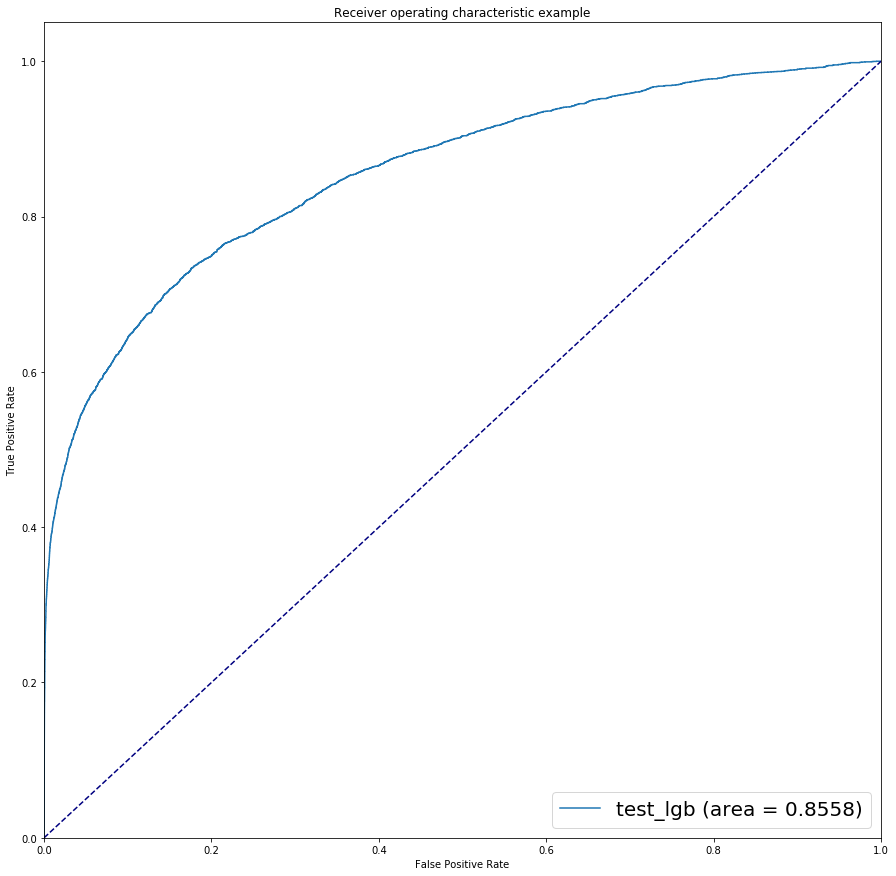

In [192]:
dtrain = lgb.Dataset(
    data=df_train_d, label=y_train
)
dvalid = lgb.Dataset(
    data=df_valid_d, label=y_valid
)

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50            
)

fig = plt.figure(figsize=(15, 15))

#------------------------------------------------------------------------------
#lgb
pred = model_lgb.predict(df_test_d)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [193]:
#Эти манипуляции также подняли точность.